# Unsupervised Learning and Semi-Supervised Models
Working with unlabeled and semi-labeled patient data since we cannot assume most clients have chosen a desired clinic to frequent.

In [0]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
%matplotlib inline

from collections import Counter

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN

from sklearn.decomposition import PCA

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV

# Keras neural net imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.convolutional import Convolution1D

# libraries for boosting
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Preprocessing
Make sure data are in the directory

In [0]:
# Load training and test sets in current working directory
x_train = pd.read_csv("x_train.csv").drop('Unnamed: 0', axis=1)
# get rid of unnamed first column and unravel (n,1) into dim (n,)
y_train = pd.read_csv("y_train.csv").drop('Unnamed: 0', axis=1).values.ravel()
x_test = pd.read_csv("x_test.csv").drop('Unnamed: 0', axis=1)
y_test = pd.read_csv("y_test.csv").drop('Unnamed: 0', axis=1).values.ravel()

In [0]:
x_combined = pd.concat([x_train,x_test], axis=0)

In [0]:
f_x_train = pd.read_csv("filtered_x_train.csv").drop('Unnamed: 0', axis=1)
f_x_test = pd.read_csv("filtered_x_test.csv").drop('Unnamed: 0', axis=1)

In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    return 'Time elapsed: %s (%s to %s)' % (asMinutes(s), asMinutes(since), asMinutes(now))

In [0]:
def scoreRMSE(predictor, X, true_y, plot = True):
    '''
    function to compute root mean squared error as well as prediction accuracy

    @args:
        predictor: model
        X: test input data
        true_y: true y labels for test data
        plot: only for boosting, plots f-scores for each booster
    '''
    predictions = predictor.predict(X)
    print("\nModel Report")
    print ("RMSE Score : %f" % np.sqrt(mean_squared_error(predictions, true_y)))
    accuracy = metrics.accuracy_score(predictions, true_y) * 100
    print("Accuracy : %.4g" % accuracy, '%')         

    if plot:
        # Print f-score:    
        feat_imp = pd.Series(predictor.get_booster().get_fscore()).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='f-score', figsize = (20, 10))
        plt.ylabel('f-score')

## Semisupervised: PCA
Perform PCA on labelled and unlabelled data. Use the fitted PCA to transform labelled data, which is used as input for training.

In [0]:
n_components = 8
pca = PCA(n_components=n_components, whiten=False)

start = time.time()

# fit using all input data
pca.fit(x_combined)

# generate transformed projections for combined x, x_train, and x_test
x_pca = pca.transform(x_train)
x_train_pca = pd.DataFrame(x_pca)
x_pca = pca.transform(x_test)
x_test_pca = pd.DataFrame(x_pca)
x_pca = pca.transform(x_combined)
x_combined_pca = pd.DataFrame(x_pca)

In [0]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Dataset Explained Variance')
plt.show()

### Supervised Training on PCA projections

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


# Number of trees in random forest
n_estimators = n_estimators = list(range(10, 100, 10))

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = list(range(10, 30, 10))
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [0]:
print ("learning...")
rfc = RandomForestClassifier(min_samples_split=10)
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(x_train_pca, y_train)
print(rf_random.best_params_) #{'bootstrap': True, 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 30, 'n_estimators': 300, 'min_samples_leaf': 2}
print("\nTraining Results")
scoreRMSE(rf_random, x_train_pca, y_train, plot = False) 
print("\nEvaluation Results")
scoreRMSE(rf_random, x_test_pca, y_test, plot = False)
print ("done learning")

## Active Learning/Pseudo-labeling
Train supervised model on labelled data to provide pseudo-labels for unlabelled data. Then train a fresh model on the combined labelled and pseudo-labeled data

In [0]:
# we build off of our PCA work and use pca data

# pseudo labels predicted by model
y_test_ps = rf_random.predict(x_test_pca)

# concat labelled and model-labelled data
y_combined_ps = np.concatenate([y_train,y_test_ps], axis=0)

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


# Number of trees in random forest
n_estimators = n_estimators = list(range(10, 100, 10))

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = list(range(10, 30, 10))
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [0]:
print ("learning...")
rfc = RandomForestClassifier(min_samples_split=10)
rf_rand_ps = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

rf_rand_ps.fit(x_combined_pca, y_combined_ps)
print(rf_rand_ps.best_params_) #{'bootstrap': True, 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 30, 'n_estimators': 300, 'min_samples_leaf': 2}
print("\nTraining Results")
scoreRMSE(rf_rand_ps, x_train_pca, y_train, plot = False) 
print("\nEvaluation Results")
scoreRMSE(rf_rand_ps, x_test_pca, y_test, plot = False)
print ("done learning")

## Unsupervised: Clustering

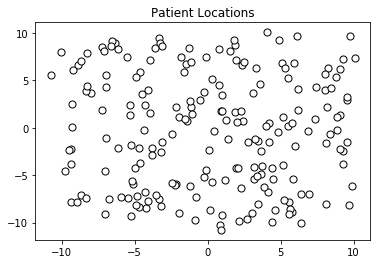

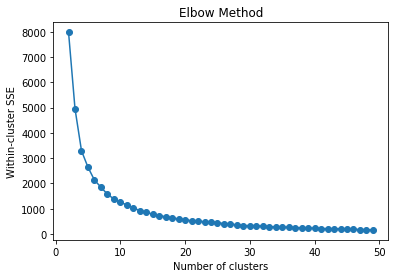

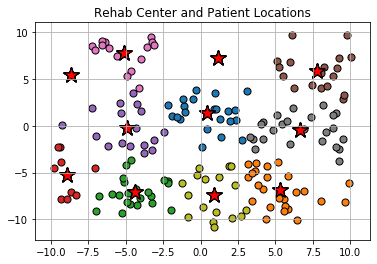

In [32]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import random

# Generating random locations of patients on 2D map...
patient_num = 200
c = random.randint(1,patient_num)

X, y = make_blobs(
   n_samples=patient_num, n_features=2,
   centers=c, cluster_std=0.5,
   shuffle=True, random_state=0
)

plt.title("Patient Locations")
plt.scatter(
   X[:, 0], X[:, 1],
   c='white', marker='o',
   edgecolor='black', s=50
)
plt.show()

SSE = []
models = []

# Find best cluster number and locations
max_cluster_count = 50
for k in range(2, max_cluster_count):
  km = KMeans(
    n_clusters=k, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
  )
  y_km = km.fit_predict(X)
  SSE.append(km.inertia_)
  models.append((y_km, km))

# Plotting the within cluster SSE
plt.title("Elbow Method")
plt.plot(range(2, max_cluster_count), SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster SSE')
plt.show()

count = 9
best = models[count]
for m in range(count):
  plt.scatter(
    X[models[count][0] == m, 0], X[models[count][0] == m, 1],
    s=50, edgecolor='black',
    label='cluster '+str(m)
  ) 
  plt.scatter(
    models[count][1].cluster_centers_[:, 0], models[count][1].cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black'
  )
#plt.legend(scatterpoints=1)
plt.title("Rehab Center and Patient Locations")
plt.grid()
plt.show()